
- 20240536 Inês Jacinto 20240536@novaims.unl.pt
- 20211639 Rui Lourenço 20211639@novaims.unl.pt 
- 20240561 Antônio Ramos 20240561@novaims.unl.pt 
- 20240662 Chiel Groeneveld 20240662@novaims.unl.pt 
- 20240598 Sofia Jacinto 20240598@novaims.unl.pt 
- 20240750 Marisa Marques 20240750@novaims.unl.pt


In [1]:
# General Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn packages
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_selection import RFE

from sklearn.model_selection import StratifiedKFold

# embedded methods
from sklearn.linear_model import LassoCV
import scipy.stats as stats
from scipy.stats import chi2_contingency

from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import classification_report, f1_score

from util_train import *
from utils import *
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

In [2]:
reference_date = pd.to_datetime("2023-01-01")

In [3]:
train_df = pd.read_csv("./data/train_data_after_EDA.csv", index_col="Claim Identifier")

In [4]:
numerical_features = [
    "Age at Injury",
    "WCIO Cause of Injury Code",
    "WCIO Nature of Injury Code",
    "WCIO Part Of Body Code",
    "Number of Dependents",
    "Years Past Accident",
    "Assembly Years past Accident",
    "Industry Code",
    "Birth Year",
    "Average Weekly Wage",
    "IME-4 Count"
]

categorical_features = [
    "Carrier Name",
    "Carrier Type",
    "County of Injury",
    "District Name",
    "Gender",
    "Medical Fee Region",
    "Zip Code"
]

binary_features = [
    "Attorney/Representative",
    "COVID-19 Indicator",
    "First Hearing Date Occurred",
    "C-2 Date Occurred",
    "C-3 Date Occurred"
]


In [5]:
for col in numerical_features+categorical_features+binary_features:
    if col not in train_df.columns:
        print(col)
print("-------")
for col in train_df.columns:
    if col not in numerical_features+categorical_features+binary_features:
        print(col)

-------
Accident Date
Alternative Dispute Resolution
Claim Injury Type


In [6]:
train_df.dropna(subset = ["Accident Date", "Age at Injury","Birth Year","Years Past Accident","Assembly Years past Accident"], inplace=True)

In [7]:
X = train_df.drop(["Claim Injury Type","Accident Date","Alternative Dispute Resolution"], axis = 1)
y = train_df["Claim Injury Type"]

# Feature Selection

In [8]:
X_train_90, X_test, y_train_90, y_test = train_test_split(X,y, test_size = 0.1, random_state = 69, stratify = y, shuffle = True) # 10% of data that the models never saw

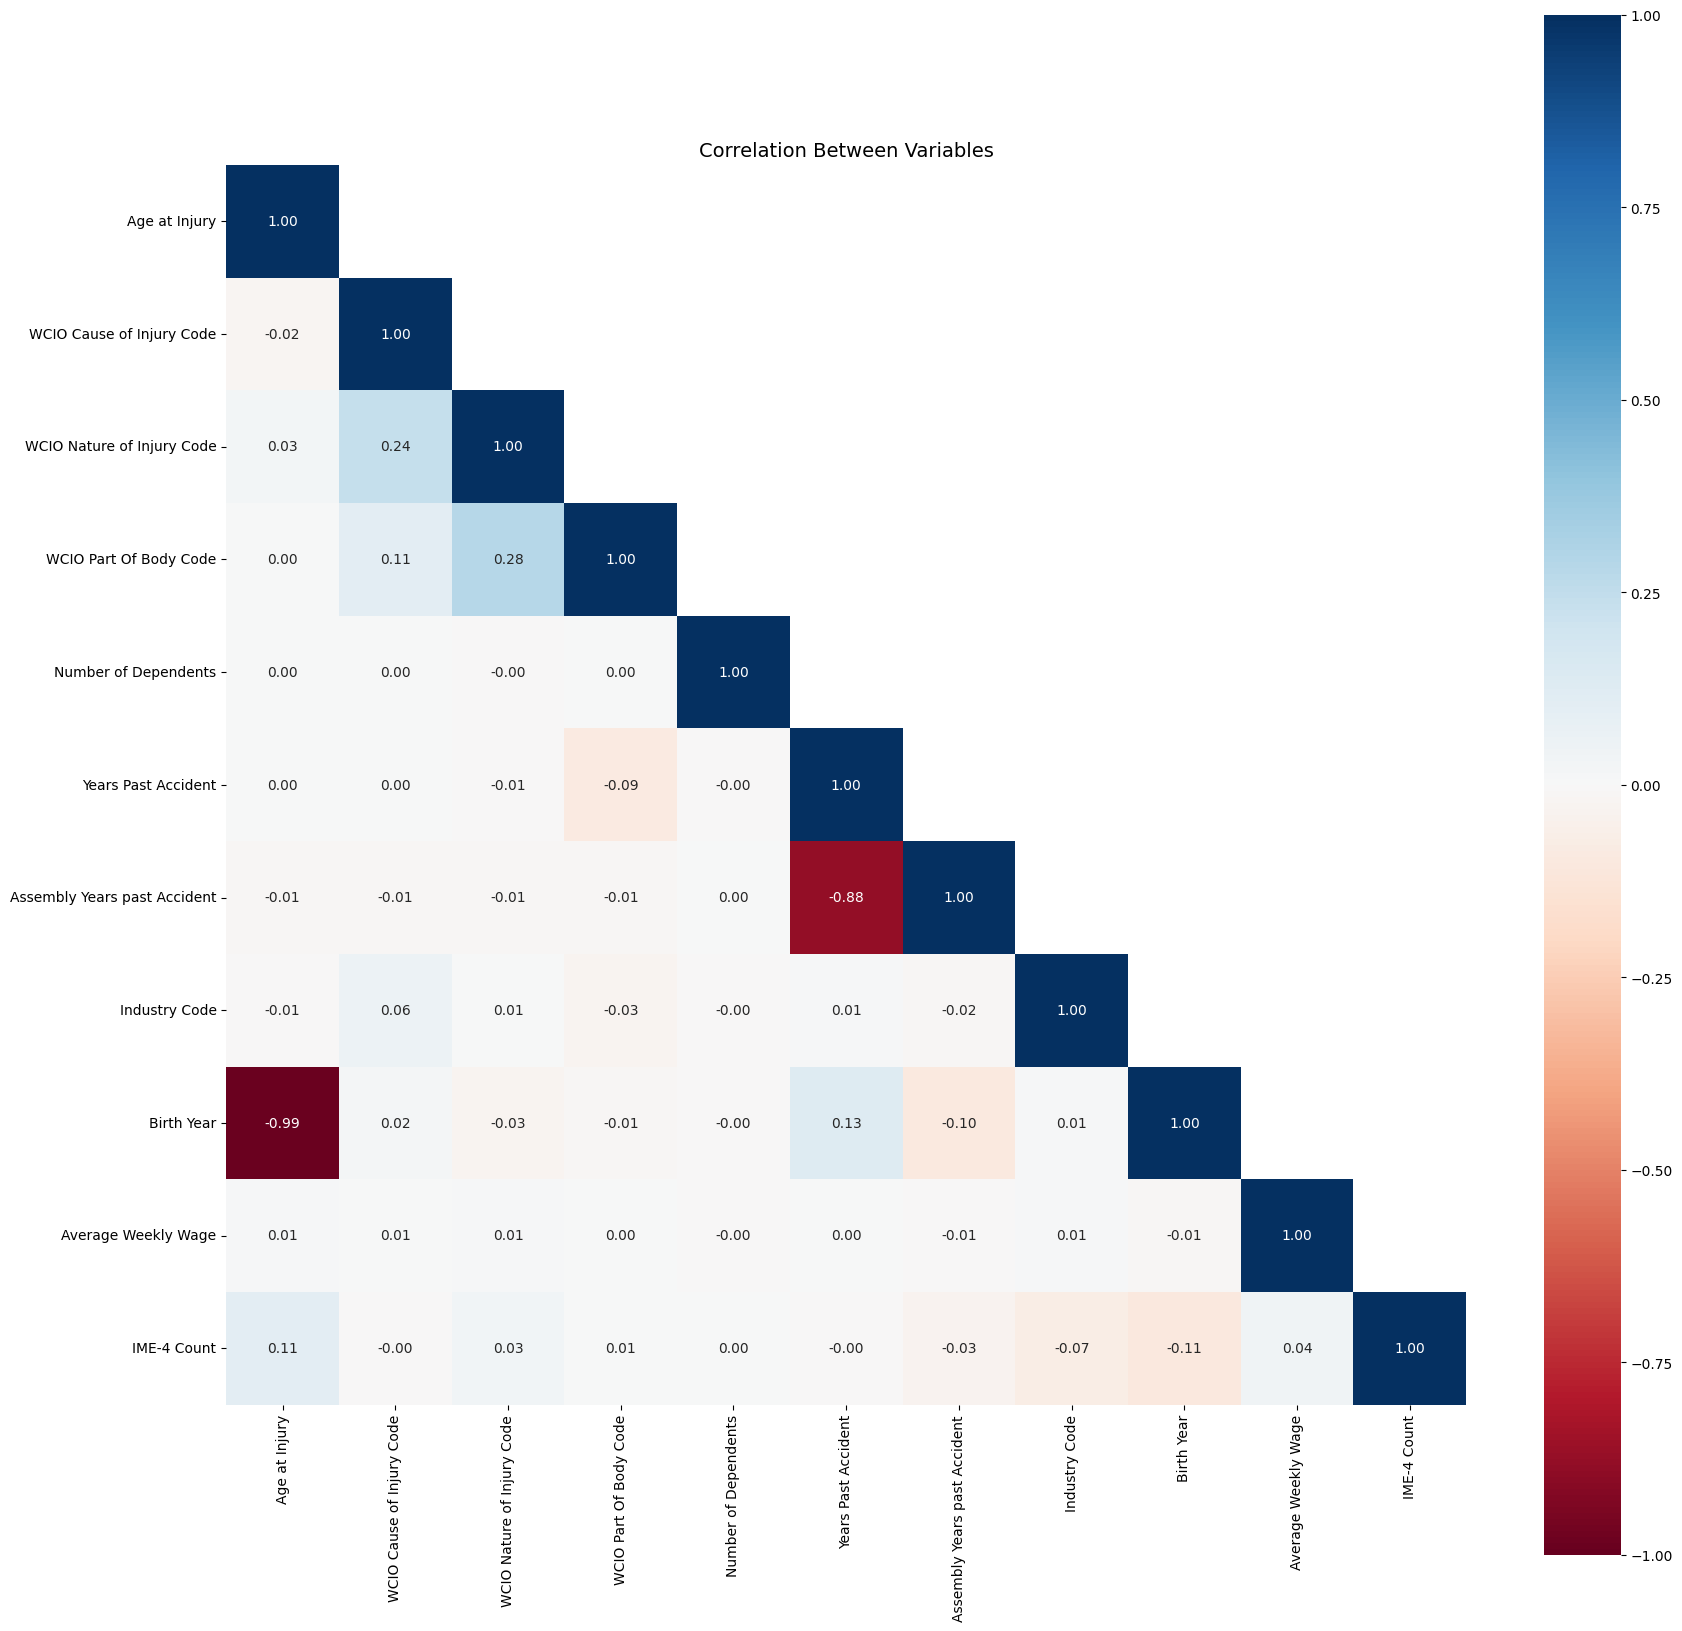

In [9]:
# initial correlation matrix with the respective values
corr_matrix = X_train_90[numerical_features].corr()

mask = np.tri(*corr_matrix.shape, k=0, dtype=bool)
# Keeps values where mask is True
corr_matrix = corr_matrix.where(mask)

# defines the figure size
fig, ax = plt.subplots(figsize=(20, 20))
# heatmap of the initial correlation matrix
l = sns.heatmap(corr_matrix, square=True, annot=True, fmt=".2f", vmax=1, vmin=-1, cmap='RdBu', ax=ax)
plt.title('Correlation Between Variables', size=14)
plt.show()

In [10]:
X_train_temp, X_val_temp, y_train_temp, y_val_temp = train_test_split(X_train_90,y_train_90, test_size = 0.25, random_state = 42, stratify = y_train_90, shuffle = True)

In [11]:
feature_to_scale = numerical_features+categorical_features
mm = MinMaxScaler()
X_train_temp[feature_to_scale] = mm.fit_transform(X_train_temp[feature_to_scale])
X_val_temp[feature_to_scale] = mm.transform(X_val_temp[feature_to_scale])

In [12]:
to_impute = ["Average Weekly Wage","Industry Code"]
imputer = KNNImputer(n_neighbors=3)
X_train_temp[to_impute] = imputer.fit_transform(X_train_temp[to_impute])
X_val_temp[to_impute] = imputer.transform(X_val_temp[to_impute])

In [13]:
RFE_XGB_best = feature_selection_RFE(X_train_temp[numerical_features],y_train_temp,n_features=len(numerical_features)
                                    ,model = xgb.XGBClassifier(
                                                    objective='binary:logistic',  
                                                    eval_metric='logloss',         
                                                    use_label_encoder=False,                 
                                                ))

In [14]:
RFE_DT_best = feature_selection_RFE(X_train_temp[numerical_features],y_train_temp,n_features=len(numerical_features)
                                    ,model = DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, class_weight='balanced'))

In [15]:
RFE_XGB_best

['WCIO Cause of Injury Code',
 'WCIO Nature of Injury Code',
 'WCIO Part Of Body Code',
 'Years Past Accident',
 'Assembly Years past Accident',
 'Industry Code',
 'Birth Year',
 'Average Weekly Wage',
 'IME-4 Count']

In [16]:
RFE_DT_best

['WCIO Nature of Injury Code', 'Average Weekly Wage', 'IME-4 Count']

In [17]:
missing_percentage = X_train_temp.isna().sum() / len(X_train_temp) * 100
for col, percent in missing_percentage.items():
    if not percent == 0:
        print(f"{col}: {percent:.2f}% missing values")

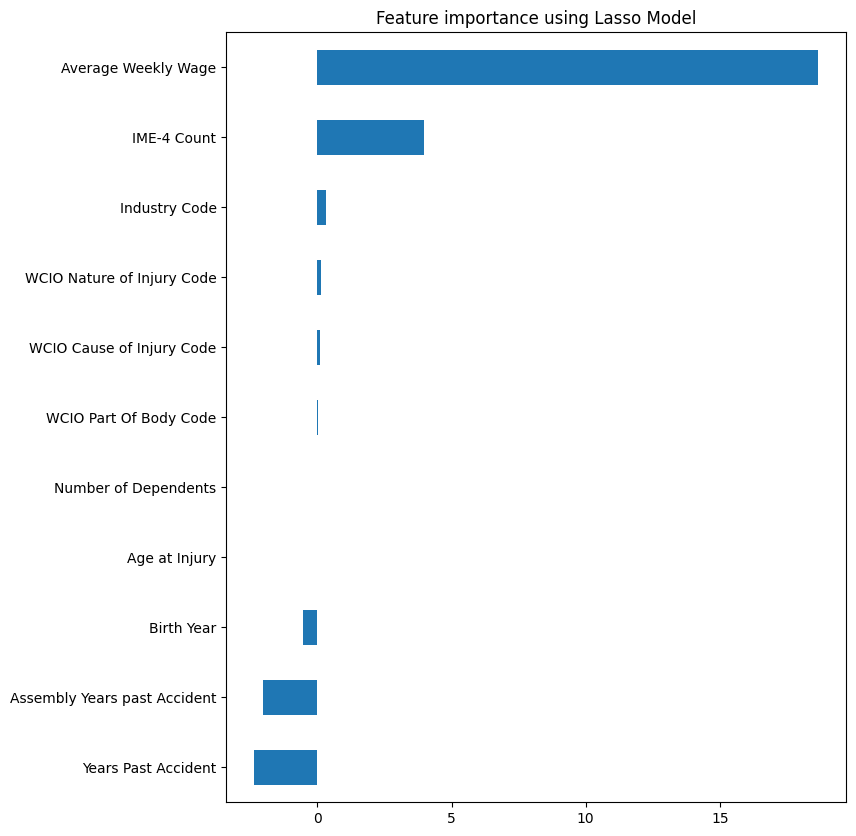

Age at Injury                    0.000000
WCIO Cause of Injury Code        0.091767
WCIO Nature of Injury Code       0.147836
WCIO Part Of Body Code           0.023691
Number of Dependents             0.000000
Years Past Accident             -2.347002
Assembly Years past Accident    -2.009943
Industry Code                    0.333748
Birth Year                      -0.518775
Average Weekly Wage             18.661475
IME-4 Count                      3.963339
dtype: float64


In [18]:
feature_selection_Lasso(X_train_temp[numerical_features],y_train_temp)

In [19]:
for col in categorical_features+binary_features:
    TestIndependence(X_train_temp[col],y,col,alpha=0.05)

Carrier Name is IMPORTANT for Prediction
Carrier Type is IMPORTANT for Prediction
County of Injury is IMPORTANT for Prediction
District Name is IMPORTANT for Prediction
Gender is IMPORTANT for Prediction
Medical Fee Region is IMPORTANT for Prediction
Zip Code is IMPORTANT for Prediction
Attorney/Representative is IMPORTANT for Prediction
COVID-19 Indicator is IMPORTANT for Prediction
First Hearing Date Occurred is IMPORTANT for Prediction
C-2 Date Occurred is IMPORTANT for Prediction
C-3 Date Occurred is IMPORTANT for Prediction


<hr>

### Numerical Data

| Predictor | Spearman | RFE XGB| RFE DT | Lasso | What to do? (One possible way to "solve") |
| --- | --- | --- | --- |--- |---|
| Age at Injury | Keep? | Discard | Discard |Discard | Discard |
| IME-4 Count | Keep | Keep | Keep |Keep| Include in the model |
| WCIO Cause of Injury Code | Keep| Keep | Discard | Discard | Try with and without |
| WCIO Nature of Injury Code | Keep | Keep | Keep | Discard | Include in the model |
| WCIO Part Of Body Code | Keep | Keep | Discard | Discard | Try with and without |
| Number of Dependents | Keep | Discard | Discard | Discard | Discard |
| Years Past Accident | Keep | Keep | Discard | Keep | Include in the model |
| Assembly Years past Accident | Discard |Keep |Discart | Keep |  Discard | # Years Past Accident
| Industry Code | Keep |Keep |Discard | Keep |   Include in the model |
| Birth Year | Keep? |Keep |Discard | Keep |  Try with and without |
| Average Weekly Wage | Keep |Keep |Keep | Keep |  Include in the model |

<hr>

### Categorical Data

| Predictor | Chi-Square |
| --- | --- |
| Carrier Name | Keep |  
| Carrier Type | Keep |
| County of Injury| Keep|
| District Name| Keep|
| Gender | Keep |
| Medical Fee Region | Keep |
| Attorney/Representative | Keep |
| COVID-19 Indicator | Keep |
| First Hearing Date Occurred | Keep |
| C-2 Date Occurred | Keep |
| C-3 Date Occurred| Keep |
| Birth Year Occurred | Keep |
| Age at Injury Occurred | Keep |
| Accident Date Occurred | KEEP |

<hr>

# Model Training

In [20]:
features_to_drop = ["Number of Dependents","Assembly Years past Accident","Birth Year",
                   "Age at Injury","WCIO Part Of Body Code","WCIO Cause of Injury Code"
                   ]
features_to_scale = ["IME-4 Count","WCIO Nature of Injury Code",
                     "Years Past Accident","Industry Code","Average Weekly Wage"] + categorical_features

In [21]:
X_train_90.drop(features_to_drop,axis=1,inplace=True)

In [22]:
print(X_train_90.columns)
features_to_use = [feature for feature in X_train_90.columns]

Index(['Attorney/Representative', 'Average Weekly Wage', 'Carrier Name',
       'Carrier Type', 'County of Injury', 'COVID-19 Indicator',
       'District Name', 'Gender', 'IME-4 Count', 'Industry Code',
       'Medical Fee Region', 'WCIO Nature of Injury Code', 'Zip Code',
       'Years Past Accident', 'First Hearing Date Occurred',
       'C-2 Date Occurred', 'C-3 Date Occurred'],
      dtype='object')


In [23]:
XGB = xgb.XGBClassifier(
                model = xgb.XGBClassifier(
                use_label_encoder=False,  
                n_estimators=100, 
                max_depth=6, 
                learning_rate=0.1,        
                random_state=42           
            ))

RF = RandomForestClassifier(
    n_estimators=100,         
    max_depth=None,            
    min_samples_split=2,       
    min_samples_leaf=1,        
    random_state=42,           
    n_jobs=-1,                
)

DT = DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, random_state=None)

In [24]:
#check_performace(XGB,X_train_90,y_train_90,features_to_scale,n_folds = 5)

In [25]:
#check_performace(RF,X_train_90,y_train_90,features_to_scale,n_folds = 5)

In [26]:
#check_performace(DT,X_train_90,y_train_90,features_to_scale,n_folds = 5)

In [27]:
X_train, X_val, y_train, y_val = train_test_split(X_train_90,y_train_90, test_size = 0.25, random_state = 42, stratify = y_train_90, shuffle = True)

scaler = StandardScaler().fit(X_train[features_to_scale])
X_train[features_to_scale]  = scaler.transform(X_train[features_to_scale])
X_val[features_to_scale]  = scaler.transform(X_val[features_to_scale])  

to_impute = ["Average Weekly Wage","Industry Code"]
imputer = KNNImputer(n_neighbors=3)
X_train[to_impute] = imputer.fit_transform(X_train[to_impute])
X_val[to_impute] = imputer.transform(X_val[to_impute])

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)      

XGB.fit(X_train, y_train)
y_val_XGB_pred = XGB.predict(X_val)

RF.fit(X_train, y_train)
y_val_RF_pred = RF.predict(X_val)

DT.fit(X_train, y_train)
y_val_DT_pred = DT.predict(X_val)

f1_XGB = f1_score(y_val, y_val_XGB_pred, average='macro')
f1_RF = f1_score(y_val, y_val_RF_pred, average='macro')
f1_DT = f1_score(y_val, y_val_DT_pred, average='macro')

print(f"Validation XGB f1 score: {f1_XGB}")
print(f"Validation RF f1 score: {f1_RF}")
print(f"Validation DT f1 score: {f1_DT}")

Validation XGB f1 score: 0.42390379296788855
Validation RF f1 score: 0.42654206489232677
Validation DT f1 score: 0.2847050042316506


In [28]:
X_test.drop(features_to_drop, axis=1, inplace=True)

In [29]:
to_impute = ["Average Weekly Wage","Industry Code"]

X_test[features_to_scale]  = scaler.transform(X_test[features_to_scale]) 
X_test[to_impute] = imputer.transform(X_test[to_impute])

XGB_pred = XGB.predict(X_test)
RF_pred = RF.predict(X_test)
DT_pred = DT.predict(X_test)

In [30]:
print(classification_report(y_test, XGB_pred))

              precision    recall  f1-score   support

           0       0.46      0.58      0.51      1074
           1       0.86      0.94      0.90     28803
           2       0.38      0.15      0.22      6862
           3       0.74      0.75      0.75     14791
           4       0.59      0.62      0.60      4826
           5       0.10      0.24      0.14       421
           6       0.00      0.00      0.00        10
           7       0.14      0.51      0.22        47

    accuracy                           0.76     56834
   macro avg       0.41      0.48      0.42     56834
weighted avg       0.74      0.76      0.74     56834



In [31]:
print(classification_report(y_test, RF_pred))

              precision    recall  f1-score   support

           0       0.50      0.55      0.53      1074
           1       0.87      0.92      0.89     28803
           2       0.33      0.19      0.24      6862
           3       0.72      0.76      0.74     14791
           4       0.57      0.61      0.59      4826
           5       0.08      0.05      0.06       421
           6       0.00      0.00      0.00        10
           7       0.25      0.30      0.27        47

    accuracy                           0.75     56834
   macro avg       0.42      0.42      0.42     56834
weighted avg       0.73      0.75      0.74     56834



In [32]:
print(classification_report(y_test, DT_pred))

              precision    recall  f1-score   support

           0       0.21      0.59      0.31      1074
           1       0.86      0.89      0.88     28803
           2       0.38      0.04      0.08      6862
           3       0.68      0.35      0.46     14791
           4       0.40      0.41      0.41      4826
           5       0.04      0.86      0.08       421
           6       0.00      0.20      0.00        10
           7       0.02      0.45      0.04        47

    accuracy                           0.60     56834
   macro avg       0.32      0.47      0.28     56834
weighted avg       0.70      0.60      0.61     56834



In [33]:
test_df = pd.read_csv("./data/test_data.csv", index_col="Claim Identifier")
submission = pd.read_csv("./data/sample_submission.csv")
test_encoder_dict = {}

In [34]:
missing_percentage = test_df.isna().sum() / len(test_df) * 100
for col, percent in missing_percentage.items():
    if not percent == 0:
        print(f"{col}: {percent:.2f}% missing values")

Accident Date: 0.63% missing values
Average Weekly Wage: 4.95% missing values
Birth Year: 5.02% missing values
C-2 Date: 2.35% missing values
C-3 Date: 78.04% missing values
First Hearing Date: 88.91% missing values
IME-4 Count: 90.91% missing values
Industry Code: 1.99% missing values
Industry Code Description: 1.99% missing values
OIICS Nature of Injury Description: 100.00% missing values
WCIO Cause of Injury Code: 2.67% missing values
WCIO Cause of Injury Description: 2.67% missing values
WCIO Nature of Injury Code: 2.72% missing values
WCIO Nature of Injury Description: 2.72% missing values
WCIO Part Of Body Code: 2.46% missing values
WCIO Part Of Body Description: 2.46% missing values
Zip Code: 4.99% missing values


In [35]:
features_to_encode_freq = [ 
    "Carrier Name", "County of Injury", "District Name", "Gender", "Medical Fee Region", "Zip Code"]

features_to_encode_binary = ["Attorney/Representative", "COVID-19 Indicator", "Carrier Type", "Alternative Dispute Resolution"]

features_descriptions = ["Industry Code Description","WCIO Cause of Injury Description", "WCIO Cause of Injury Description",
                        "WCIO Nature of Injury Description", "WCIO Part Of Body Description", "OIICS Nature of Injury Description",
                         "Accident Date"
]

features_to_dummy = ["First Hearing Date", "C-2 Date", "C-3 Date"]
features_to_days = ["Assembly Date"]

In [36]:
test_df['Accident Date'] = pd.to_datetime(test_df['Accident Date'], errors='coerce')
test_df['Birth Year'] = test_df['Birth Year'].fillna(
    test_df['Accident Date'].dt.year - test_df['Age at Injury']
)

In [37]:
zip_code_anomalies = test_df[test_df['Zip Code'].notna()  # 'Zip Code' is not missing
        & test_df['Zip Code'].apply(lambda x: not str(x).isnumeric())]  # 'Zip Code' is not numeric

In [38]:
test_df.loc[test_df['Zip Code'].isin(zip_code_anomalies['Zip Code']), 'Zip Code'] = np.nan
test_df["Age at Injury"] = test_df["Age at Injury"].replace(0, np.nan)
test_df["Birth Year"] = test_df["Birth Year"].replace(0, np.nan)
test_df["Gender"] = test_df["Gender"].replace("U","X")
test_df["IME-4 Count"].fillna(0,inplace=True)
test_df["WCIO Cause of Injury Code"].fillna(0,inplace=True)
test_df["WCIO Nature of Injury Code"].fillna(0,inplace=True)
test_df["WCIO Part Of Body Code"].fillna(0,inplace=True)
test_df["Zip Code"].fillna(0,inplace=True)
test_df["Years Past Accident"] = (pd.to_datetime(test_df["Accident Date"], errors='coerce') - reference_date).dt.days / 365.25

In [39]:
test_df.loc[test_df["IME-4 Count"] > 15, "IME-4 Count"] = 15

In [40]:
multiencoder(test_df, features_to_encode_freq, "frequency", test_encoder_dict)
multiencoder(test_df, features_to_encode_binary, "binary", test_encoder_dict)
gen_dummy(test_df,features_to_dummy)
date_past_accident(test_df, features_to_days)

In [41]:
features_to_drop_test = []

In [42]:
for feature in test_df.columns:
    if feature not in features_to_use:
        features_to_drop_test.append(feature)

In [43]:
test_df.drop(features_to_drop_test,axis=1,inplace=True)

In [44]:
test_df[features_to_scale]  = scaler.transform(test_df[features_to_scale])  

In [46]:
to_impute = ["Average Weekly Wage","Industry Code"]
test_df[to_impute] = imputer.transform(test_df[to_impute])

NotFittedError: This KNNImputer instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [47]:
make_csv = True

In [48]:
class_mapping = {0: '1. CANCELLED', 1: '2. NON-COMP', 2: '3. MED ONLY', 3: '4. TEMPORARY', 4: '5. PPD SCH LOSS', 5: '6. PPD NSL', 6: '7. PTD', 7: '8. DEATH'}
test_encoder = LabelEncoder()
test_encoder.classes_ = np.array(list(class_mapping.values()))

In [50]:
for model in [XGB,RF,DT]:
    test_pred = model.predict(test_df)
    submission["Claim Injury Type"] = test_pred
    submission["Claim Injury Type"] =test_encoder.inverse_transform(submission["Claim Injury Type"])
    if make_csv:
        version = version_control("./counter.txt")
        submission.to_csv(f"./submissions/Group45_Version{version:02}.csv", index=False)